# Initial Cleaning

In [130]:
import pandas as pd
import numpy as np

#### Loading Clean DF

In [131]:
data = pd.DataFrame(pd.read_excel('CLEAN DATA FOR PANDAS MANIPULATION.xlsx'))
for_clustering = data.copy()

#### Checking for Null Values and Duplicates

In [132]:
print(f"Total Null {for_clustering.isnull().sum().sum()}")
for_clustering.isnull().sum().reset_index().rename(columns = {'index':'Column_Names', 0:'Null Count'})


Total Null 385


,Column_Names,Null Count
0,Age,0
1,Gender,0
2,Race,0
3,Nationality,0
4,Employment status,0
...,...,...
108,Donations,0
109,Mentoring,0
110,Befriending,0
111,I currently assume a leadership role in my com...,0


In [133]:
print(f'Number of Duplicates: {for_clustering.duplicated().sum()}')

Number of Duplicates: 0


#### Removing unnecessary columns

These columns are those that have a lot of null values, subjective, and consolidations.

In [134]:
for_clustering = for_clustering.drop([
                    'Complete the sentence: "I become a senior when ______________."', 
                    'Seniorhood starts at ____ years old.',
                    'Spouse / Partner', 
                    'Are there other significant events that happened to you within the past 2 years that happened? List them down. (Indicate N.A. if not applicable)',
                    'Unnamed: 21', 
                    'Unnamed: 35', 
                    'Unnamed: 47', 
                    'Unnamed: 82', 
                    'Unnamed: 105', 
                    'Unnamed: 112'], axis=1)

In [135]:
print(f"Pruned Data Shape : {for_clustering.shape}")

Pruned Data Shape : (304, 103)


#### Identifying Ordinal Data

In [136]:
#These columns contain data with answers ranging from Strongly Disagree to Strongly Agree (will remain as int)
degree_columns = [
'To what extent do you agree with this statement: I am confident I have enough money to live the lifestyle I want / to provide for myself at this point.',
'I am managing my health issues well so I can stay active.',
'I am worried for my mental health. (e.g. dementia / depression)',
'"I don\'t want to retire, I want to keep on working."',
'"Working gives me a sense of purpose that I cannot find anywhere else"',
'"I am carefree and prefer not to think so much. I just want to relax and live out my years."',
'"I spend most of my time participating in activities with people in the community."',
'"I pamper myself, live life to the fullest and do things I enjoy."',
'"I actively help others and involve myself in the community. I want to continue giving to society."',
'I am proud to call myself a senior.',
'I am comfortable with being called a senior.',
'I feel valued as a senior in society.',
'I feel like society has a negative stereotype of seniors.',
'It is difficult for me to find activities to spend time meaningfully.',
'Because of my health, there are many activities I think I cannot do anymore.',
'I am / was fully-prepared for retirement.',
'If you are retired, answer this question: Retirement is what I expected it to be.',
'I think it is important for me to keep growing in life.',
'I am constantly challenging myself to achieve my goals.',
'It is easy and comfortable for me to talk to people in the community.',
'I often feel lonely.',
'I know of activities in the neighbourhood that I can take part in.',
'I feel a sense of belonging and ownership of spaces in my community. (e.g. community centres, parks, fitness corners, void decks)',
'I am confident to use technology to connect with people around me.',
'It is important for me to be involved in the community.',
'I am satisfied with my current level of involvement in the community.',
]
print(len(degree_columns))

26


In [137]:
_ = for_clustering[degree_columns] #error check

In [138]:
keywords = ['often', 'many']
ordinal_data_columns_df = for_clustering.loc[:, ~for_clustering.columns.isin(degree_columns)]

#Data that will remain as an int data type
often_many_columns = ordinal_data_columns_df.columns[ordinal_data_columns_df.columns.str.contains('|'.join(keywords))] 



In [139]:
often_many_columns = list(often_many_columns)

In [140]:
often_many_columns.extend(['Monthly household income from work (total amount of salary income by everyone in your household)', 'Total number of people living in your household including yourself'])

In [141]:
_ = for_clustering[often_many_columns] #error check

#### Identifying Categorical Data
After grouping ordinal data, it would make sense to think that the remaining columns all contain categorical data.

In [142]:
categorical_data = for_clustering.columns[~for_clustering.columns.isin(list(often_many_columns)+degree_columns)]
categorical_data = categorical_data.drop('Age')

In [143]:
_ = for_clustering[categorical_data] #error Check
len(categorical_data)

58

CHECK IF GROUPED COLUMNS = FOR CLUSTERING COLUMNS

In [144]:
print(f"Total Columns Clean: {categorical_data.shape[0]+len(degree_columns)+len(often_many_columns)+1}") #+1 here is age
print(f"Total Original DF Columns: {for_clustering.shape[1]}")

Total Columns Clean: 103
Total Original DF Columns: 103


# Clustering with KMeans

In [145]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn import metrics

Cleaning

In [146]:
#Ordinal and Numerical Data Only
kmeans_data = for_clustering.drop(columns=categorical_data)
kmeans_data_columns = kmeans_data.columns
kmeans_data.shape

(304, 45)

In [147]:
#Scaling preprocessing
scaler = preprocessing.MinMaxScaler()
scaled_kmeans_data = scaler.fit_transform(kmeans_data)
scaled_kmeans_data = pd.DataFrame(scaled_kmeans_data, columns=kmeans_data_columns)

Looking For Correlations

In [148]:

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(scaled_kmeans_data,15).reset_index().rename(
    columns={
    'level_0':'Column 1', 
    "level_1":"Column_2",
    0:'Correlation'}
    ) #save to df if you want a file

,Column 1,Column_2,Correlation
0,How often can you open up to your spouse / par...,How often can you rely on your spouse / partne...,0.840703
1,I am proud to call myself a senior.,I am comfortable with being called a senior.,0.814813
2,"""I don't want to retire, I want to keep on wor...","""Working gives me a sense of purpose that I ca...",0.777499
3,How many relatives (excluding spouse) do you s...,How many relatives do you feel close to such t...,0.719707
4,How many colleagues do you see or hear from at...,How many colleagues do you feel close to such ...,0.694075
5,How many neighbours do you see or hear from at...,How many neighbours do you feel close to such ...,0.690775
6,"""I spend most of my time participating in acti...","""I actively help others and involve myself in ...",0.656805
7,I know of activities in the neighbourhood that...,I feel a sense of belonging and ownership of s...,0.636652
8,I think it is important for me to keep growing...,I am constantly challenging myself to achieve ...,0.628000
9,How many friends do you see or hear from at le...,How many friends do you feel close to such tha...,0.607884


Identifying Right Number of Clusters

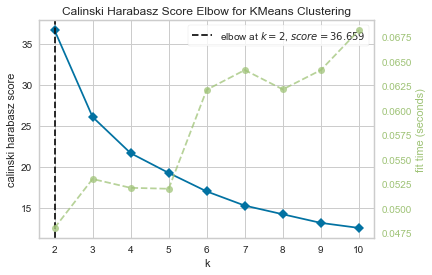

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [149]:
elbow = KElbowVisualizer(KMeans(), k=10, metric='calinski_harabasz')
elbow.fit(scaled_kmeans_data)
elbow.show()


#Notes: calinski_harabasz metric identified that optimal clusters = 2

Fitting

In [150]:
#for the sake of making sure, I will loop from k1 to k10 and compare silhouette scores. 
def best_silhouette_score():
    for i in range(2,16):
        kmeans = KMeans(n_clusters=i, random_state=69)
        kmeans.fit(scaled_kmeans_data)
        print(f"Cluster: {i} Score: {metrics.silhouette_score(scaled_kmeans_data, kmeans.labels_)}")

best_silhouette_score()
# n_clusters = 2 has the best silhouette score. Therefore it is what we will use.
        

Cluster: 2 Score: 0.0946866716590318
Cluster: 3 Score: 0.07028645185894673
Cluster: 4 Score: 0.057316718945598824
Cluster: 5 Score: 0.057496655835702765
Cluster: 6 Score: 0.05570373313336295
Cluster: 7 Score: 0.04949308419861078
Cluster: 8 Score: 0.0507511229434971
Cluster: 9 Score: 0.051306102880726144
Cluster: 10 Score: 0.04087924518284707
Cluster: 11 Score: 0.046808391310721974
Cluster: 12 Score: 0.04187587255413129
Cluster: 13 Score: 0.04354016730393677
Cluster: 14 Score: 0.03805474552107998
Cluster: 15 Score: 0.0478818675611754


In [151]:
#Final Fitting
kmeans = KMeans(n_clusters=2, random_state=69)
kmeans.fit(scaled_kmeans_data)

labels = kmeans.labels_
unique, counts = np.unique(kmeans.labels_, return_counts=True) #distribution of labels
print(dict(zip(unique, counts)))

{0: 168, 1: 136}


Plot

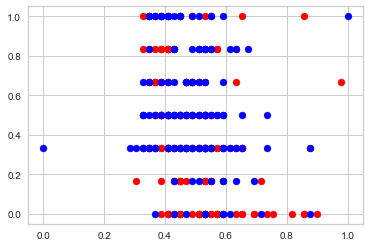

In [152]:
def plotting_cluster():
    plotting = scaler.fit_transform(kmeans_data) #data in array form
    k = KMeans(n_clusters=2, random_state=69)
    label = k.fit_predict(plotting)
    #filter rows of original data
    filtered_label0 = df[label == 0]
    filtered_label1 = df[label == 1]
    
    #plotting the results
    plt.scatter(filtered_label0[:,0] , filtered_label0[:,1],color='red')
    plt.scatter(filtered_label1[:,0] , filtered_label1[:,1],color='blue')

    plt.show()

plotting_cluster()


# Random Forest

In [153]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [154]:
rf_data = scaled_kmeans_data
rf_data['labels'] = labels

Fitting

In [155]:
train = rf_data.drop(columns='labels')
test = rf_data['labels']
X_train, X_test, y_train, y_test=train_test_split(train,test ,test_size=0.30,random_state=69)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(212, 45) (92, 45) (212,) (92,)


In [156]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)


Text(0.5, 1.0, 'Feature Importance Ranking')

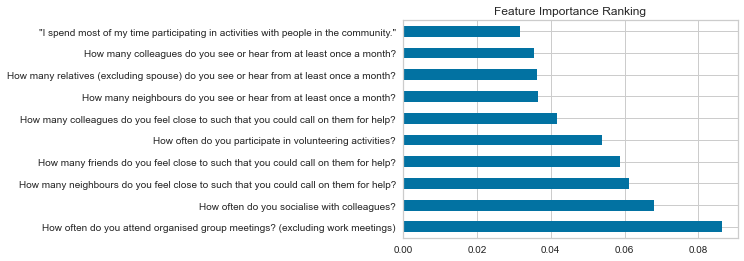

In [157]:
feature_importances=rf.feature_importances_
feature_importances_df=pd.DataFrame({'Variable':list(X_train), 'Variable importance':feature_importances})

feature_importances_df.sort_values('Variable importance',ascending=False)

feat_importances = pd.Series(rf.feature_importances_, index=train.columns)

feat_importances.nlargest(10).plot(kind='barh')
plt.title("Feature Importance Ranking")

# FOR SAVING

In [159]:
importance_df = feature_importances_df.sort_values(by='Variable importance',ascending=False) #for excel save

labeled_df = kmeans_data
labeled_df['labels'] = labels #for excel save

top_15_most_correlated = get_top_abs_correlations(scaled_kmeans_data,15).reset_index().rename(columns={'level_0':'Column 1', "level_1":"Column_2",0:'Correlation'})
